### Wet-Chicken problem BNN_LV with PYMC3
Using Metropolis-Hastings sampling in pymc3 to sample from posterior of BNN_LV

Samples saved out: `saved_samples/chicken_samples_pymc3.npy` UPDATE THIS

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import sys
import pymc3 as pm
import arviz as az
import seaborn as sns
# from pymc3.theanof import MRG_RandomStreams, set_tt_rng
import theano.tensor as tt
from tqdm import tqdm
from numpy.random import default_rng
import time
from IPython.core.debugger import set_trace
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs
from utils.BNN_pymc3 import BNN_LV as BNN_LV_pymc3
from utils.custom_callbacks_pymc3 import plot95ci, wb_scatter, build_wb_callback
from utils.decomposition import chicken_entropy_decompose

In [4]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

np.set_printoptions(precision=3, suppress=True)
RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)

## Wet Chicken

In [5]:
from utils.games import WetChicken2D

### Set up simulation and extract data

In [6]:
env = WetChicken2D(L=5, W=3, max_steps=20, seed=207)
no_action_policy = lambda state: (0,0)  # For any state, play the "do nothing" action.
random_policy = None  # If the policy is None, the simulator chooses an action at random.

# choose to run on the no-action policy
env.run(episodes=100, progress=100, policy=no_action_policy)

Episode 100/100 took 4 steps.


In [7]:
transitions = env.extract_transition_dataset()
transitions = transitions.sample(frac=1, replace=False, random_state=123)
transitions

start_x  start_y  action_x  action_y  result_x  result_y
344        1        5         0         0         1         5
482        3        4         0         0         3         0
78         3        4         0         0         3         1
185        1        5         0         0         1         5
261        1        5         0         0         1         5
..       ...      ...       ...       ...       ...       ...
98         1        5         0         0         1         5
322        1        5         0         0         1         5
382        1        5         0         0         1         5
365        2        2         0         0         2         0
510        3        3         0         0         3         3

[845 rows x 6 columns]

In [8]:
# Build training data (ignore X dimension and try to use starting Y position and Y action to predict landing Y position):
X_train = transitions[['start_x','start_y','action_x','action_y']].to_numpy()
Y_train = transitions[['result_x','result_y']].to_numpy()

print('X :',X_train.shape)
print('Y :',Y_train.shape)


X : (845, 4)
Y : (845, 2)


### Setup BNN_LV architecture and perform MLE fit

In [9]:
# Parameters
gamma_chicken = 2 #was 1
sigma_chicken = 1

architecture_chicken = {'input_n':4, 
             'output_n':2, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma_chicken],
             'sigma':[sigma_chicken,sigma_chicken]}

bnn_lv_chicken = BNN_LV_pymc3(architecture=architecture_chicken)

bnn_lv_chicken.fit(X_train, Y_train, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 470.2068084910165; gradient mag: 2692.02567206901
Iteration 500 lower bound 0.3379868859524919; gradient mag: 0.16344421229072587
Iteration 1000 lower bound 0.3196073602042975; gradient mag: 0.047922578659930756
Iteration 1500 lower bound 0.31298184663365974; gradient mag: 0.06370773740865066
Iteration 2000 lower bound 0.3086818274918602; gradient mag: 0.0217583871960227
Iteration 2500 lower bound 0.3082039426835888; gradient mag: 0.009102998075831087
Iteration 3000 lower bound 0.3080744981492027; gradient mag: 0.005910595193040041
Iteration 3500 lower bound 0.30877366619455393; gradient mag: 2.366463392384662
Iteration 4000 lower bound 0.30797493539442244; gradient mag: 0.41351640190098243
Iteration 4500 lower bound 0.3080640871930079; gradient mag: 1.0899469717314474


### Prepare parameters for pymc3 sampling

In [10]:
p_mu = 0
p_sigma = 5
l_sigma = 0.25
lv_gamma = 2 # usual, multiplied by 2

my_tune = 10000 #was 500 / 40000
my_draws = 10000 #was 400 / 40000
my_target_accept = 0.99
my_max_treedepth = 15

### Run pymc3

In [53]:
from fastprogress import fastprogress
fastprogress.printing = lambda: True

with pm.Model() as pm_model: #change name (e.g. pm_model2) to have multiple models in one notebook

    # Prior on w (same shape as MLE)
    w_prior = pm.Uniform(name='w', lower=-0.001, upper=0.001, shape=bnn_lv_chicken.weights.shape)
    
    # Latent variable prior (same shape as number of datapoints)
    lv_prior = pm.Uniform(name='z', lower=-0.001, upper=0.001, shape=(X_train.shape[0],1))
    
    #likelihood
    y = pm.Normal(name='y', mu = bnn_lv_chicken.forward(X = X_train, input_noise = lv_prior, weights=w_prior),
                        sigma = l_sigma,
                        observed = Y_train)


    step = pm.Metropolis([w_prior, lv_prior], target_accept=my_target_accept)
    
    trace = pm.sample(step=step, tune=my_tune, draws=my_draws, return_inferencedata=False, random_seed=RANDOM_SEED) #, start = {'w': bnn_lv_chicken.weights}
                                                            #set inferencedata==True when checking if chain means are equal 
                                                            #and comment idata 

    #prior analysis
    prior_pc = pm.sample_prior_predictive()
    
    #posterior predictive
    ppc = pm.fast_sample_posterior_predictive(trace=trace)
    
    #generate inference data
    idata = az.from_pymc3(trace=trace, prior=prior_pc, posterior_predictive=ppc, log_likelihood=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [z]
>Metropolis: [w]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [129]:
np.save('/Users/lievegobbels/PycharmProjects/decomposition-of-uncertainty/chicken/saved_samples/chicken_samples_pymc3MET-2.npy',trace['w'])

In [62]:
posterior_samples_pymc3_chicken = np.load('/Users/lievegobbels/PycharmProjects/decomposition-of-uncertainty/chicken/saved_samples/chicken_samples_pymc3MET-2.npy')

In [65]:
posterior_samples_pymc3_chicken.shape

(40000, 1, 582)

In [66]:
#thinning by factor of 4
posterior_samples_pymc3_chicken = posterior_samples_pymc3_chicken[::20, :]
posterior_samples_pymc3_chicken.shape

(2000, 1, 582)

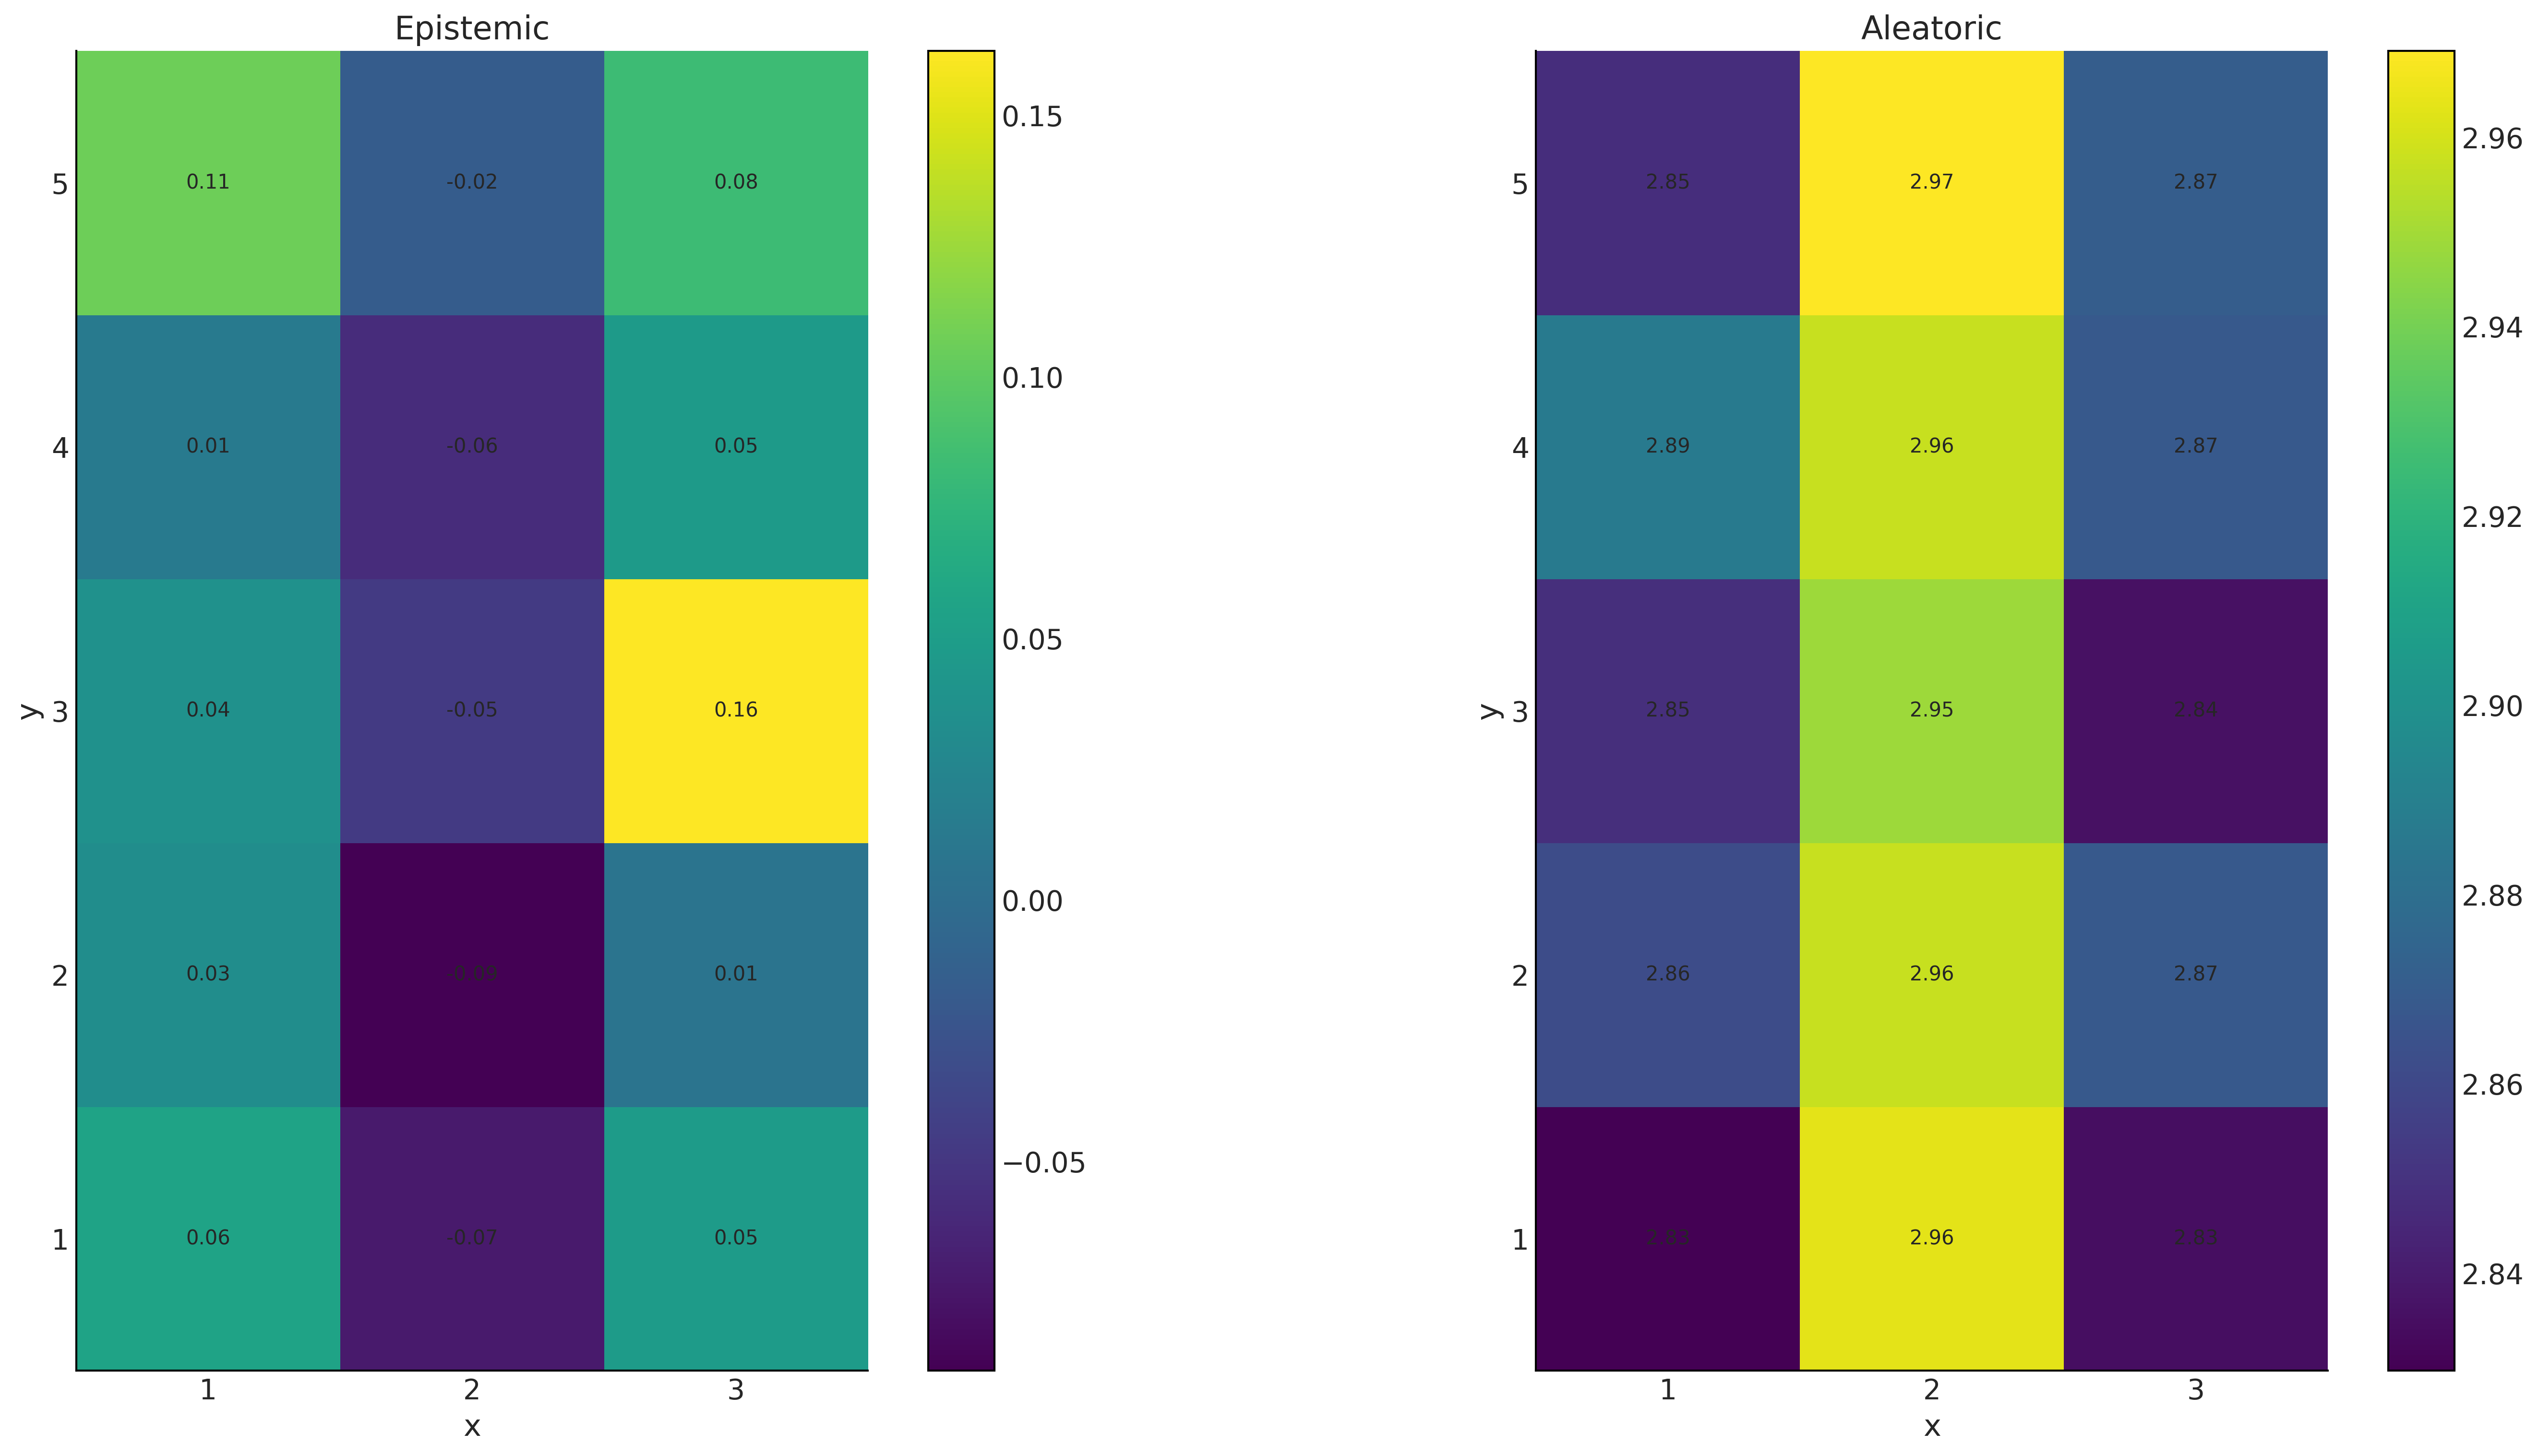

In [70]:
az.style.use("arviz-white")
N = 90 # number of 15 pt repeats
N2 = 10 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
#chicken_decomp_nuts = chicken_entropy_decompose(bnn_lv_chicken, transitions, posterior_samples_pymc3_chicken, N, N2, L)
chicken_decomp_nuts = chicken_entropy_decompose(bnn_lv_chicken, transitions, posterior_samples_pymc3_chicken, N, N2, L)


### Data cloning analysis for assessing likelihood non-identifiability

Steps:  

1. Perform Bayesian inference with a likelihood based on the original data (K=1), using uninformative priors on all parameters. 

2. Record the posterior variance for the parameters.  

3. Create a data set consisting of K clones, that is, the data repeated K times.

4. Perform Bayesian inference with a likelihood based on the cloned data set of step 3, using uninformative priors on all parameters.

5. Record the posterior variance for the parameters. Scale this variance by dividing through by the posterior variance for K=1, found in step 2.

6. Repeat steps 3 to 5 for successively larger values of K.

7. If the scaled variance is approximately equal to 1/K for a parameter then that parameter is identifiable and can be estimated. If the standardized variance is much larger than 1/K then that parameter is non-identifiable and cannot be estimated. If there is at least on non-identifiable parameter, then the model with that set of data is parameter redundant. 


In [50]:
#step 2
var_1 = idata.posterior.var(("chain", "draw"))
var_1

<xarray.Dataset>
Dimensions:  (w_dim_0: 1, w_dim_1: 582, z_dim_0: 845, z_dim_1: 1)
Coordinates:
  * w_dim_0  (w_dim_0) int64 0
  * w_dim_1  (w_dim_1) int64 0 1 2 3 4 5 6 7 ... 574 575 576 577 578 579 580 581
  * z_dim_0  (z_dim_0) int64 0 1 2 3 4 5 6 7 ... 837 838 839 840 841 842 843 844
  * z_dim_1  (z_dim_1) int64 0
Data variables:
    w        (w_dim_0, w_dim_1) float64 0.08863 0.1395 ... 0.09278 0.06494
    z        (z_dim_0, z_dim_1) float64 0.3266 0.2135 0.1499 ... 0.2037 0.6135

In [63]:
#step 3
K = 4
clone = np.repeat(Y_train, K, axis=0)
clone
#Y_train

array([[1, 5],
       [1, 5],
       [1, 5],
       ...,
       [3, 3],
       [3, 3],
       [3, 3]])

In [66]:
#step 3b
clone_X = np.repeat(X_train, K, axis=0)

In [70]:
#step 4
from fastprogress import fastprogress
fastprogress.printing = lambda: True

with pm.Model() as pm_model2: #change name (e.g. pm_model2) to have multiple models in one notebook

    # Prior on w (same shape as MLE)
    #w_prior = pm.Normal(name='w', mu=p_mu, sigma=p_sigma, shape=bnn_lv_chicken.weights.shape) #MAKE THIS UNIFORM FOR TESTING SUCCESFULL ADDITION NON_IDENTIFIABILITY???
    w_prior2 = pm.Uniform(name='w', lower=-25, upper=25, shape=bnn_lv_chicken.weights.shape)
    
    # Latent variable prior (same shape as number of datapoints)
    #lv_prior = pm.Uniform(name='z', lower=-99999999999, upper=99999999999, shape=(X_train.shape[0],1)) #MAKE THIS UNIFORM FOR TESTING SUCCESFUL ADDITION NON_IDENTIFIABILITY???
    lv_prior2 = pm.Uniform(name='z', lower=-1, upper=1, shape=(clone_X.shape[0],1))
    

    y2 = pm.Normal(name='y', mu = bnn_lv_chicken.forward(X = clone_X, input_noise = lv_prior2, weights=w_prior2),
                        sigma = l_sigma,
                        observed = clone)

#     trace = pm.sample_smc(tune=my_tune, draws=my_draws, start = {'w': bnn_lv_chicken.weights},
#                          target_accept=my_target_accept, max_treedepth=my_max_treedepth)

    step2 = pm.Metropolis([w_prior2, lv_prior2], target_accept=my_target_accept)
    
    trace2 = pm.sample(step=step2, tune=my_tune, draws=my_draws, return_inferencedata=False, random_seed=RANDOM_SEED) #, start = {'w': bnn_lv_chicken.weights}
                                                            #set inferencedata==True when checking if chain means are equal 
                                                            #and comment idata 

    #prior analysis
    prior_pc2 = pm.sample_prior_predictive()
    
    #posterior predictive
    ppc2 = pm.fast_sample_posterior_predictive(trace=trace2)
    
    #generate inference data
    idata2 = az.from_pymc3(trace=trace2, prior=prior_pc2, posterior_predictive=ppc2, log_likelihood=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [z]
>Metropolis: [w]


/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 140 seconds.
The rha

In [71]:
#step 5
var_K = idata2.posterior.var(("chain", "draw"))
var_K

<xarray.Dataset>
Dimensions:  (w_dim_0: 1, w_dim_1: 582, z_dim_0: 3380, z_dim_1: 1)
Coordinates:
  * w_dim_0  (w_dim_0) int64 0
  * w_dim_1  (w_dim_1) int64 0 1 2 3 4 5 6 7 ... 574 575 576 577 578 579 580 581
  * z_dim_0  (z_dim_0) int64 0 1 2 3 4 5 6 ... 3374 3375 3376 3377 3378 3379
  * z_dim_1  (z_dim_1) int64 0
Data variables:
    w        (w_dim_0, w_dim_1) float64 0.07964 0.3335 0.0796 ... 0.01028 0.1238
    z        (z_dim_0, z_dim_1) float64 0.1192 0.1568 0.1789 ... 0.1905 0.4495

In [72]:
#step 5b
scaled_var = var_K / var_1
scaled_var

<xarray.Dataset>
Dimensions:  (z_dim_0: 845, w_dim_0: 1, w_dim_1: 582, z_dim_1: 1)
Coordinates:
  * z_dim_0  (z_dim_0) int64 0 1 2 3 4 5 6 7 ... 837 838 839 840 841 842 843 844
  * w_dim_0  (w_dim_0) int64 0
  * w_dim_1  (w_dim_1) int64 0 1 2 3 4 5 6 7 ... 574 575 576 577 578 579 580 581
  * z_dim_1  (z_dim_1) int64 0
Data variables:
    w        (w_dim_0, w_dim_1) float64 0.8985 2.391 0.8318 ... 0.1108 1.906
    z        (z_dim_0, z_dim_1) float64 0.365 0.7343 1.194 ... 1.663 0.4088

In [77]:
from scipy import stats

In [95]:
#step 7 check difference between scaled variance and 1/K for a parameter 
#if non-id, scaled_var >> 1/K

def difference(array, value):
    
    diff = []
    for i in array:
        delta = abs(i - value)
        diff.append(delta)
    
    return diff

def test_dif(diff, value, p): 
    
    for i in diff:
        if i > (1+p)*value:
            return print("""Difference is significant, so there is non-identifiability.""")
        else:
            continue
    
    return print("""Difference is not significant, so the model is identifiable.""")

In [99]:
#check difference between scaled variance and 1/K for a parameter 
#if non-id, scaled_var >> 1/K
scaled_var_z = scaled_var['z'][:,0].to_numpy()
scaled_var_w = scaled_var['w'][0,:].to_numpy()


test_dif(difference(scaled_var_z, 1/K), 1/K, 0.10)
#min(difference(scaled_var_z, 1/K))
test_dif(difference(scaled_var_w, 1/K), 1/K, 0.10)

Difference is significant, so there is non-identifiability.
Difference is significant, so there is non-identifiability.


In [100]:
#this is not entirely suitable (I think) because even if 1 value is significantly different,
#there is already non-identifiability
stats.ttest_1samp(scaled_var_z, 1/K)
stats.ttest_1samp(scaled_var_w, 1/K)

Ttest_1sampResult(statistic=5.876538561084291, pvalue=7.06216463217506e-09)

### Trying R code in python

In [39]:
import rpy2
from rpy2 import robjects
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x13db63808> [RTYPES.NILSXP]

In [41]:
utils.install_packages("MCMCvis")
MCMCvis = importr("MCMCvis")

R[write to console]: Installing package into ‘/Users/lievegobbels/Library/R/3.5/library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘StanHeaders’, ‘RcppEigen’, ‘rstan’





  There are binary versions available but the source versions are later:
               binary    source needs_compilation
StanHeaders  2.21.0-1  2.21.0-7              TRUE
RcppEigen   0.3.3.7.0 0.3.3.9.2              TRUE
rstan          2.19.3    2.21.5              TRUE
MCMCvis        0.13.5    0.15.5             FALSE

Do you want to install from sources the packages which need compilation? (Yes/no/cancel) no


R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/el-capitan/contrib/3.5/StanHeaders_2.21.0-1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1530768 bytes (1.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to 


The downloaded binary packages are in
	/var/folders/b2/bwp46gcj1hd2l2s5lj1mm2z80000gn/T//Rtmpwmm0nm/downloaded_packages


R[write to console]: installing the source package ‘MCMCvis’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/MCMCvis_0.15.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 4169069 bytes (4.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [43]:
MCMCtrace = robjects.r['MCMCtrace']

In [45]:
#MCMCtrace(Y_train, params='w', priors=idata.prior, pdf=False)

### Prior and posterior plots and calculations

In [79]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [44]:
# some functions
def OVL_two_random_arr(arr1, arr2, number_bins):
    
    # Determine the range over which the integration will occur
    min_value = np.min((arr1.min(), arr2.min()))
    max_value = np.min((arr1.max(), arr2.max()))
    # Determine the bin width
    bin_width = (max_value-min_value)/number_bins
    #For each bin, find min frequency
    lower_bound = min_value #Lower bound of the first bin is the min_value of both arrays
    min_arr = np.empty(number_bins) #Array that will collect the min frequency in each bin
    for b in tqdm(range(number_bins)):
        higher_bound = lower_bound + bin_width #Set the higher bound for the bin
        #Determine the share of samples in the interval
        freq_arr1 = np.ma.masked_where((arr1<lower_bound)|(arr1>=higher_bound), arr1).count()/len(arr1)
        freq_arr2 = np.ma.masked_where((arr2<lower_bound)|(arr2>=higher_bound), arr2).count()/len(arr2)
        #Conserve the lower frequency
        min_arr[b] = np.min((freq_arr1, freq_arr2))
        lower_bound = higher_bound #To move to the next range
        pass
    return min_arr.sum() 

def dim_reduction(ndarray):
    
    if ndarray.shape[2] > 1 | ndarray.shape[3] == 1:
        arr = ndarray[0,:,:,0]
    
    elif ndarray.shape[3] > 1 | ndarray.shape[2] == 1:
        arr = ndarray[0,:,0,:]
    
    elif ndarray.shape[2] > 1 | ndarray.shape[3] > 1:
        arr = [ndarray[0,:,:,0], ndarray[0,:,:,1]]
    
    return arr

def sample (arr, p):
    
    mask = np.random.choice([False, True], len(arr), p=[1-p, p])
    sample = arr[mask]
    
    return sample

def PPO (sample1, sample2, n, t):
    
    overlaps = []
    
    for i in range(len(sample1)):
        overlap = OVL_two_random_arr(sample1[i], sample2[i], n)
        overlaps.append(overlap)
    
    if t == 'mean':
        return np.mean(overlaps)
    
    elif t == 'max': 
        return max(overlaps)
    
    elif t == 'min':
        return min(overlaps)
    
    elif t == 'all':
        return overlaps

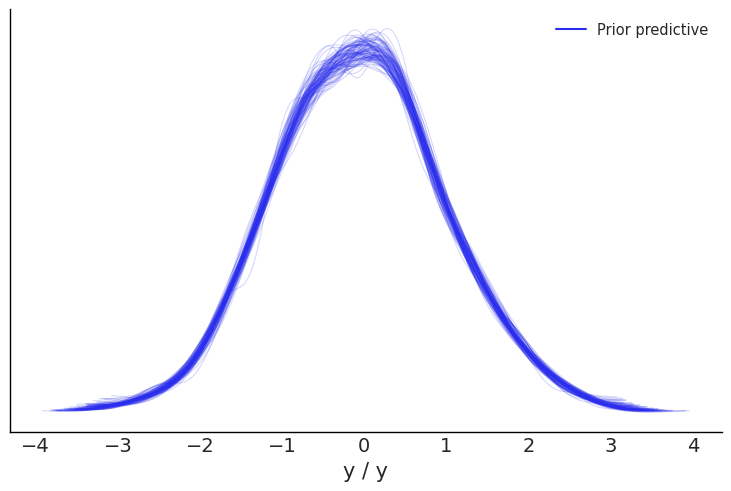

In [71]:
# prior
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='prior');

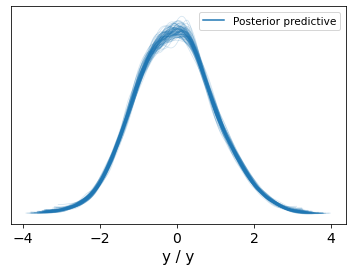

In [55]:
# posterior
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='posterior');

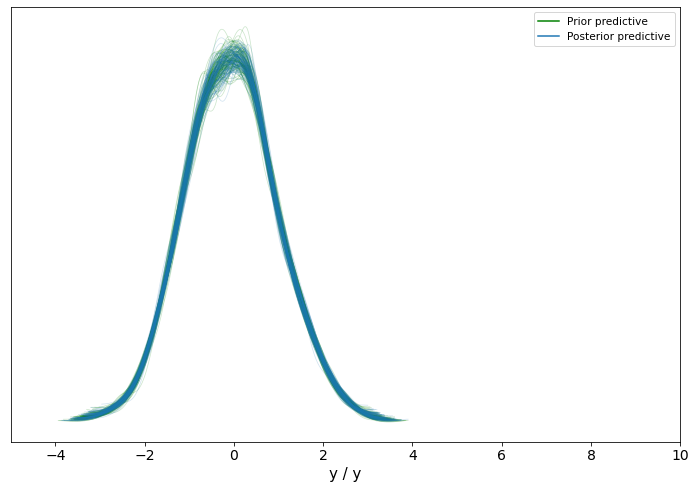

In [56]:
#prior and posterior in one plot

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
# plt.ylim(-0.05,0.3)
plt.show()

#the result is very pleasing: if the overlap between the two distributions low, it means 
#the "data was informative enough to overcome the influence of the prior" --> identifiable pars!!

/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (845), generating only 20 plots
  UserWarning,


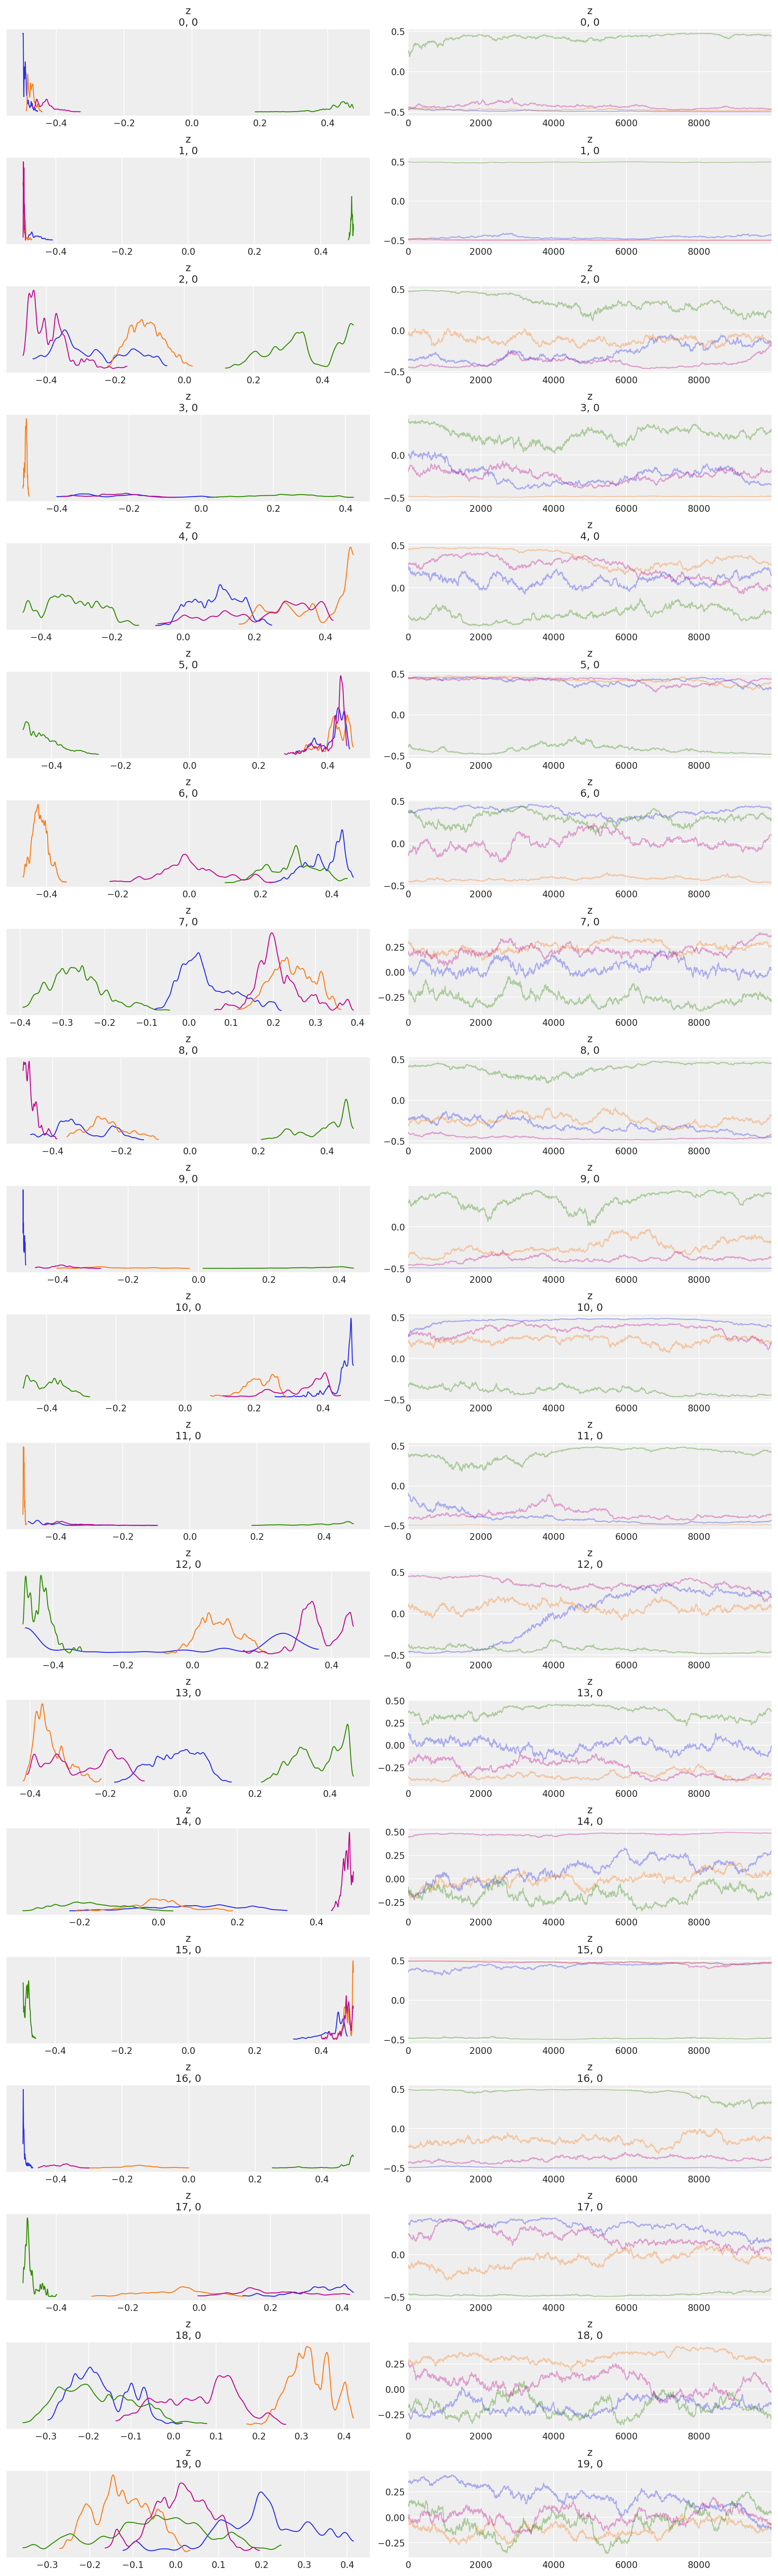

In [19]:
with pm_model:
    az.plot_trace(trace, var_names=['z'], compact=False);

In [20]:
with pm_model:
    pm.plot_posterior(trace)

/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1427) in plot_posterior, generating only 40 plots
  UserWarning,


In [21]:
mu = []
for i in idata.posterior.chain.values:
    mu.append(np.mean(idata.posterior['w'][i,:,0,1]))

print(mu)

[<xarray.DataArray 'w' ()>
array(-0.382)
Coordinates:
    chain    int64 0
    w_dim_0  int64 0
    w_dim_1  int64 1, <xarray.DataArray 'w' ()>
array(-0.329)
Coordinates:
    chain    int64 1
    w_dim_0  int64 0
    w_dim_1  int64 1, <xarray.DataArray 'w' ()>
array(-0.028)
Coordinates:
    chain    int64 2
    w_dim_0  int64 0
    w_dim_1  int64 1, <xarray.DataArray 'w' ()>
array(0.388)
Coordinates:
    chain    int64 3
    w_dim_0  int64 0
    w_dim_1  int64 1]


In [22]:
with pm_model:    
    axes = az.plot_pair(trace, var_names='w', scatter_kwargs={'alpha':0.5})

    for ax in axes.flat:
        ax.set_xlabel(None);
        ax.set_ylabel(None);

    axes[0,0].figure.tight_layout();

/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:242: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,
/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


In [31]:
sigma = idata.posterior_predictive.var(("chain", "draw"))
#sigma['y'][:,0]

In [155]:
prior = idata.prior
post = idata.posterior
prior_w = prior['w'].to_numpy()
prior_z = prior['z'].to_numpy()
post_w = post['w'].to_numpy()
post_z = post['z'].to_numpy()

In [149]:
mu_post = idata.posterior_predictive.mean(("chain", "draw"))
mu_prior = idata.prior_predictive.mean(("chain", "draw"))

mu_post = mu_post['y'].to_numpy()
mu_prior = mu_prior['y'].to_numpy()
len(mu_post)

845

In [27]:
from arviz.stats.density_utils import get_bins, histogram, kde

In [57]:
observed_data = idata.observed_data
priorpredictive_dataset = idata.prior_predictive 
postpredictive_dataset = idata.posterior_predictive

coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]

# prior_xarray = priorpredictive_dataset.isel(coords)
# post_xarray = postpredictive_dataset.isel(coords)
# prior_arrays = [prior_xarray['y'][i].values.flatten() for i in flatten_pp]
# prior_arrays = [i for j in prior_arrays for i in j]
# prior_array = np.array(prior_arrays)
# prior_array


#prior_xarray['y']
# arrays = [predictive_dataset[i].values.flatten() for i in flatten_pp]
# arrays = [i for j in arrays for i in j]
# array = np.array(arrays)

In [59]:
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
# prior_arrays = [i for j in prior_arrays for i in j]
# prior_array = np.array(prior_arrays)
# prior_array
#post_array

In [60]:
OVL_two_random_arr(prior_array, post_array, 100)

100%|██████████| 100/100 [11:04<00:00,  6.64s/it]


0.9961034911242604

In [31]:
##### part of code of plot_ppc internals, use this + more for determining mean of prior and post
##### and plug those values in OVL_two_random_arr to check if overlap is ±0.80 as shown in plot

predictive_dataset = idata.posterior_predictive #or prior_predictive if chosen
total_pp_samples = predictive_dataset.sizes["chain"] * predictive_dataset.sizes["draw"]
num_pp_samples = 100 #should be between 1 and 500
pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]

print(predictive_dataset.isel(coords))

# fig, axes = create_axes_grid(length_plotters, rows, cols, backend_kwargs=backend_kwargs)

# for i, ax_i in enumerate(np.ravel(axes)[:length_plotters]):
#         var_name, selection, isel, obs_vals = obs_plotters[i]
#         pp_var_name, _, _, pp_vals = pp_plotters[i]
        


pp_vals = pp_vals.reshape(total_pp_samples, -1)
pp_sampled_vals = pp_vals[pp_sample_ix]

pp_densities = []
pp_xs = []
for vals in pp_sampled_vals:
    vals = np.array([vals]).flatten()

pp_x, pp_density = kde(vals)
pp_densities.append(pp_density)
pp_xs.append(pp_x)
bins = get_bins(vals)
_, hist, bin_edges = histogram(vals, bins=bins)
hist = np.concatenate((hist[:1], hist))
pp_densities.append(hist)
pp_xs.append(bin_edges)

# rep = len(pp_densities)
# len_density = len(pp_densities[0])

# new_x = np.linspace(np.min(pp_xs), np.max(pp_xs), len_density)
# new_d = np.zeros((rep, len_density))
# bins = np.digitize(pp_xs, new_x, right=True)
# new_x -= (new_x[1] - new_x[0]) / 2
# for irep in range(rep):
#     new_d[irep][bins[irep]] = pp_densities[irep]

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 10000, y_dim_0: 845, y_dim_1: 2)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5 6 7 ... 837 838 839 840 841 842 843 844
  * y_dim_1  (y_dim_1) int64 0 1
Data variables:
    y        (chain, draw, y_dim_0, y_dim_1) float64 1.697 3.282 ... 2.465
Attributes:
    created_at:                 2022-05-13T10:11:02.627754
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.5


NameError: name 'pp_vals' is not defined

In [ ]:



rep = len(pp_densities)
len_density = len(pp_densities[0])
new_x = np.linspace(np.min(pp_xs), np.max(pp_xs), len_density)
new_d = np.zeros((rep, len_density))
bins = np.digitize(pp_xs, new_x, right=True)
new_x -= (new_x[1] - new_x[0]) / 2

for irep in range(rep):
    new_d[irep][bins[irep]] = pp_densities[irep]
    
mean_d = new_d.mean(0)

In [13]:
observed_data = idata.observed_data
predictive_dataset = idata.posterior_predictive #or prior_predictive if chosen

var_names = list(observed_data.data_vars)
# pp_var_names = [data_pairs.get(var, var) for var in var_names]
# pp_var_names = _var_names(pp_var_names, predictive_dataset)

flatten_pp = list(predictive_dataset.dims.keys())

coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
flatten_pp


['chain', 'draw', 'y_dim_0', 'y_dim_1']

In [18]:
predictive_dataset = idata.posterior_predictive #or prior_predictive if chosen
flatten_pp = list(predictive_dataset.dims.keys())

arrays = [predictive_dataset[i].values.flatten() for i in flatten_pp]
arrays = [i for j in arrays for i in j]
array = np.array(arrays)


AttributeError: 'DataArray' object has no attribute 'flatten'

\> 35% means weak i.e. non-identifiability

In [168]:
#overlap first column Y_train
OVL_two_random_arr(mu_prior[:,0], mu_post[:,0], 10000)

0.09822485207100592

In [169]:
#overlap second column Y_train
OVL_two_random_arr(mu_prior[:,1], mu_post[:,1], 10000)

0.02603550295857988

In [171]:
OVL_two_random_arr(mu_prior, mu_post2, 10000)

0.19171597633136098

In [163]:
#PPO of weights --> do this for y (the predictives)
sample1 = sample(dim_reduction(prior_w), 0.50)
sample2 = sample(dim_reduction(post_w), 0.50)

PPO(sample1, sample2, 10000, 'mean')

0.05369082820533312

In [77]:
#PPO of latents
sample3 = sample(dim_reduction(prior_z), 0.20)
sample4 = sample(dim_reduction(post_z), 0.20)

PPO(sample3, sample4, 10000, 'mean')

0.04112100916834645

In [119]:
len(sample1)

245

In [120]:
OVL_two_random_arr(sample1, sample2, 10000)/len(sample1)

0.5156489802503239

In [114]:
priorp = idata.prior_predictive
postp = idata.posterior_predictive
# priorp['y']

In [102]:
##### THERE IS SOMETHING WRONG WITH THE PPO CALCULATION!!!

In [113]:
priorpf = dim_reduction(priorp['y'])
postpf = dim_reduction(postp['y'])

#first dimension of transitions dataset (of Y_train)
sample5 = sample(priorpf[0].to_numpy().T, 0.20)
sample6 = sample(postpf[0].to_numpy().T, 0.20)

#second dimension
sample7 = sample(priorpf[1].to_numpy().T, 0.20)
sample8 = sample(postpf[1].to_numpy().T, 0.20)

PPO(sample5, sample6, 10000, 'mean')

0.019200000000000002

In [106]:
PPO(sample7, sample8, 10000, 'mean')

0.008180555555555557

In [ ]:
with pm_model:
    az.summary(trace)['r_hat'].round(2)

In [53]:
def make_diagnostic_plots(trace, axes=None,
                          min_mult=0.995, max_mult=1.005,
                          var_names=None):
    if axes is None:
        fig, axes = plt.subplots(ncols=2,
                                 sharex=False, sharey=False,
                                 figsize=(16, 6))
        
    #az.plot_energy(trace, ax=axes[0])
    
    
    rhat = az.rhat(trace, var_names=var_names).max()
    axes[1].barh(np.arange(len(rhat.variables)), rhat.to_array(),
                 tick_label=list(rhat.variables.keys()))
    axes[1].axvline(1, c='k', ls='--')

    axes[1].set_xlim(
        min_mult * min(rhat.min().to_array().min(), 1),
        max_mult * max(rhat.max().to_array().max(), 1)
    )
    axes[1].set_xlabel(r"$\hat{R}$")

    axes[1].set_ylabel("Variable")
    
    return fig, axes

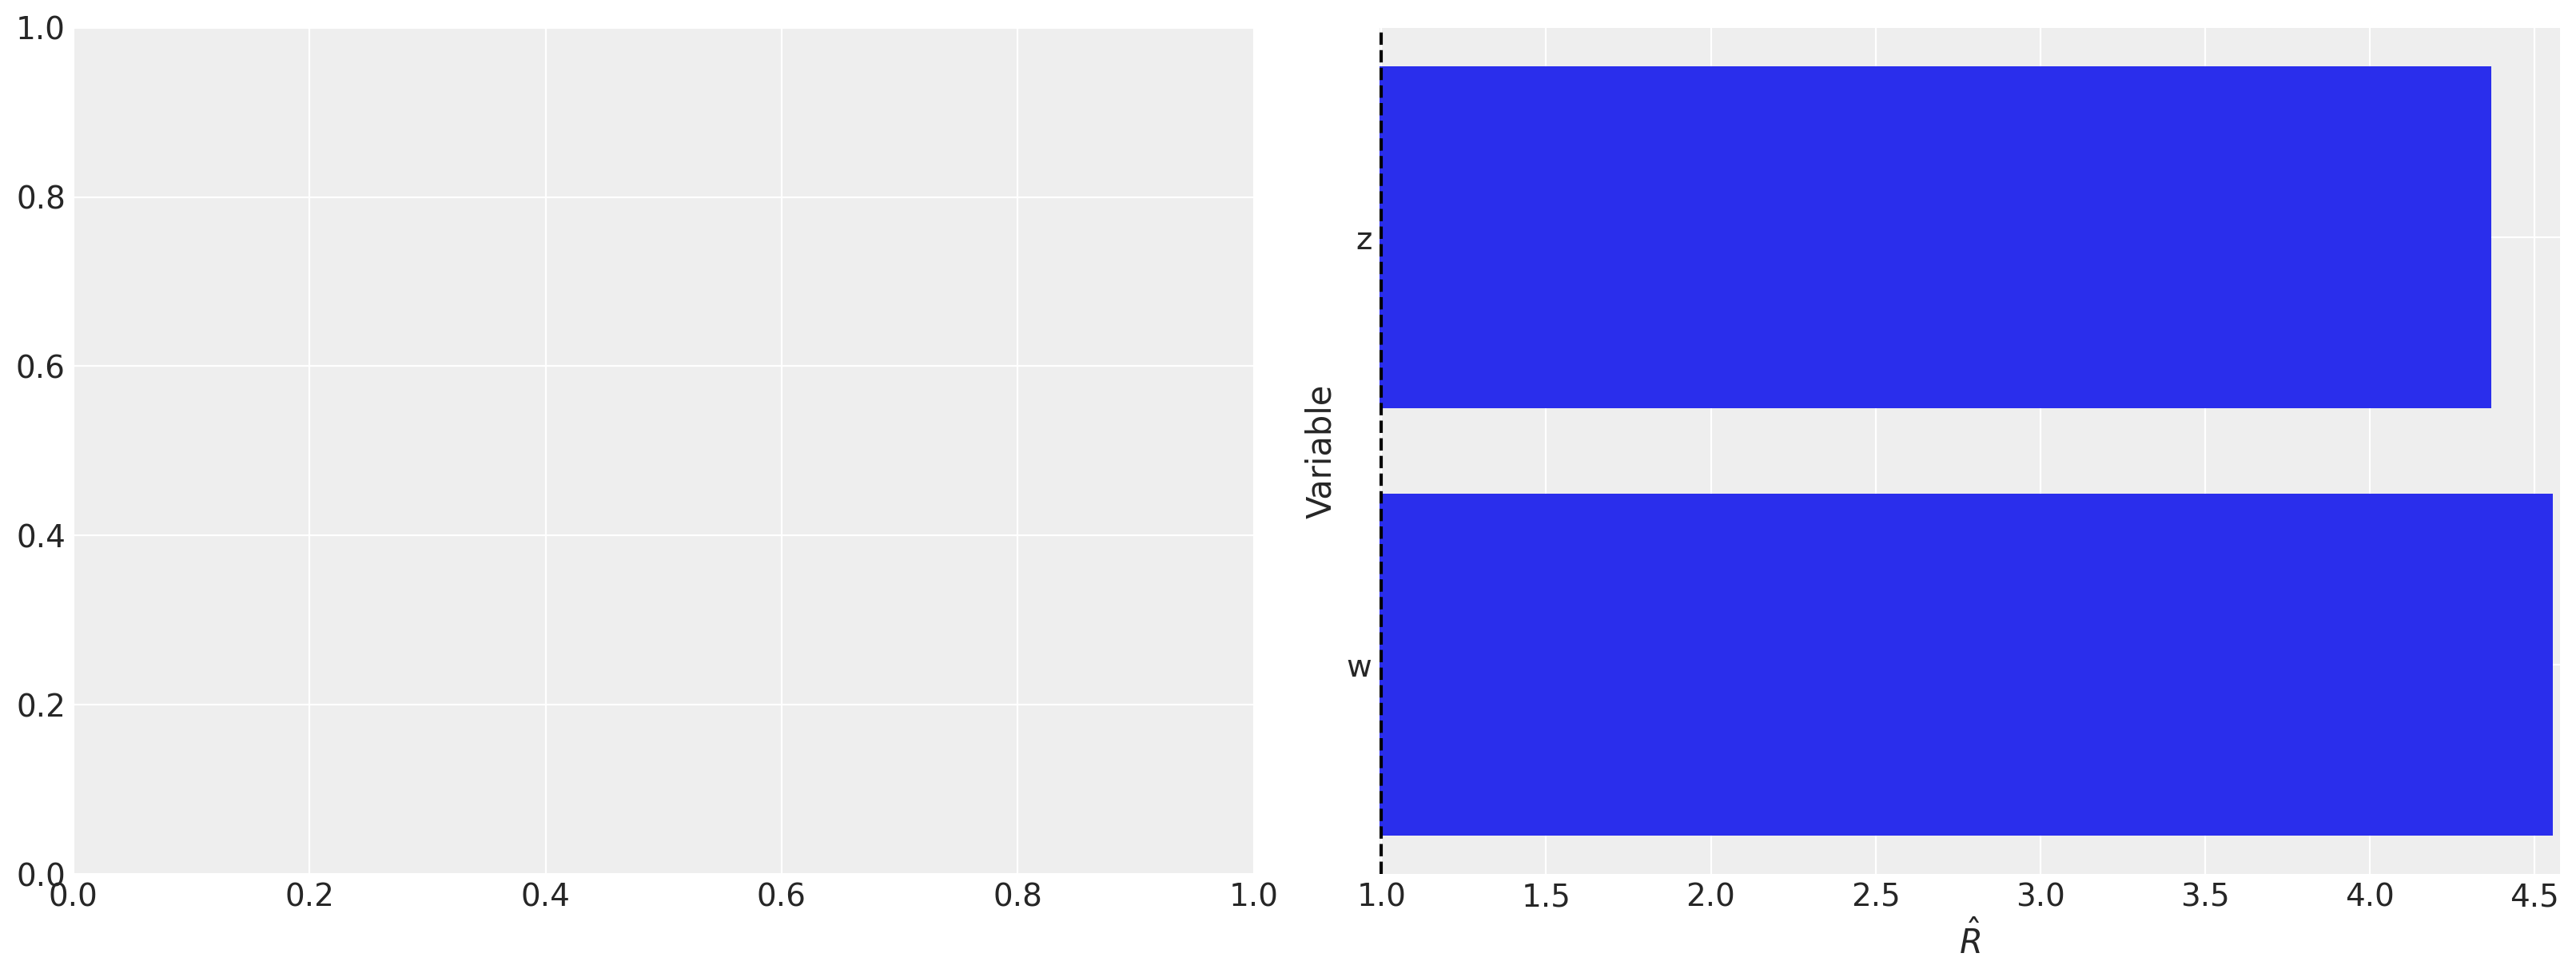

In [54]:
with pm_model:
    make_diagnostic_plots(trace);

In [55]:
idata.posterior_predictive['y'][0,0,0,0]

<xarray.DataArray 'y' ()>
array(0.16963389)
Coordinates:
    chain    int64 0
    draw     int64 0
    y_dim_0  int64 0
    y_dim_1  int64 0

In [98]:
priorp = idata.prior_predictive['y']
postp = idata.posterior_predictive['y']
# priorp = priorp.to_numpy()
# postp = priorp.to_numpy()


In [99]:
sample5 = sample(dim_reduction(priorp), 0.20)
sample6 = sample(dim_reduction(postp), 0.20)

PPO(sample5, sample6, 20000, 'mean')

TypeError: only integer scalar arrays can be converted to a scalar index

## Other plots (that are probably wrong)

In [145]:
# az.plot_trace(trace, combined=True)

# plt.savefig('trace_CpHMC.png', dpi=300)

In [146]:
# logpost = sns.distplot(trace.get_sampler_stats('model_logp'))
# fig = logpost.get_figure()
# fig.savefig('logpost_CpHMC.png', dpi=300)

In [147]:
# pm.plot_posterior(trace)
# plt.savefig('postpw_CpHMC', dpi=300)
# pass

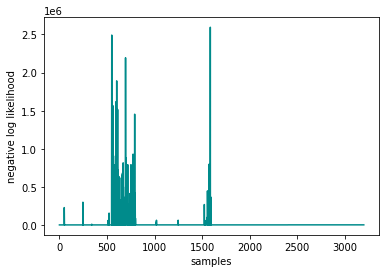

In [69]:
### Prior and posterior plots and calculations

# some functions
def OVL_two_random_arr(arr1, arr2, number_bins):
    # Determine the range over which the integration will occur
    min_value = np.min((arr1.min(), arr2.min()))
    max_value = np.min((arr1.max(), arr2.max()))
    # Determine the bin width
    bin_width = (max_value-min_value)/number_bins
    #For each bin, find min frequency
    lower_bound = min_value #Lower bound of the first bin is the min_value of both arrays
    min_arr = np.empty(number_bins) #Array that will collect the min frequency in each bin
    for b in range(number_bins):
        higher_bound = lower_bound + bin_width #Set the higher bound for the bin
        #Determine the share of samples in the interval
        freq_arr1 = np.ma.masked_where((arr1<lower_bound)|(arr1>=higher_bound), arr1).count()/len(arr1)
        freq_arr2 = np.ma.masked_where((arr2<lower_bound)|(arr2>=higher_bound), arr2).count()/len(arr2)
        #Conserve the lower frequency
        min_arr[b] = np.min((freq_arr1, freq_arr2))
        lower_bound = higher_bound #To move to the next range
    return min_arr.sum() 

def dim_reduction(ndarray):
    
    if ndarray.shape[2] > 1:
        arr = ndarray[0,:,:,0]
    
    elif ndarray.shape[3] > 1:
        arr = ndarray[0,:,0,:]
    
    return arr

def sample (arr, p):
    
    mask = np.random.choice([False, True], len(arr), p=[1-p, p])
    sample = arr[mask]
    
    return sample

def PPO (sample1, sample2, n, t):
    
    overlaps = []
    
    for i in range(len(sample1)):
        overlap = OVL_two_random_arr(sample1[i], sample2[i], n)
        overlaps.append(overlap)
    
    if t == 'mean':
        return np.mean(overlaps)
    
    elif t == 'max': 
        return max(overlaps)
    
    elif t == 'min':
        return min(overlaps)
    
    elif t == 'all':
        return overlaps

# prior
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='prior');

# posterior
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='posterior');

#prior and posterior in one plot

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.ylim(-0.05,0.3)
plt.show()

#the result is very pleasing: if the overlap between the two distributions low, it means 
#the "data was informative enough to overcome the influence of the prior" --> identifiable pars!!

az.plot_trace(trace, var_names=['z'], compact=False);

prior = idata.prior
post = idata.posterior
prior_w = prior['w'].to_numpy()
prior_z = prior['z'].to_numpy()
post_w = post['w'].to_numpy()
post_z = post['z'].to_numpy()

\>35% is weakly identifiable, so non-identifiable when =< 35%

#PPO of weights
sample1 = sample(dim_reduction(prior_w), 0.20)
sample2 = sample(dim_reduction(post_w), 0.20)

PPO(sample1, sample2, 20000, 'mean')

#PPO of latents
sample3 = sample(dim_reduction(prior_z), 0.20)
sample4 = sample(dim_reduction(post_z), 0.20)

PPO(sample3, sample4, 20000, 'mean')

with pm_model:
    pm.plot_posterior(trace)

## Other plots (that are probably wrong)neg_LL = -1 * trace.get_sampler_stats('model_logp')

plt.plot(neg_LL, color='darkcyan')
plt.xlabel('samples')
plt.ylabel('negative log likelihood')
plt.savefig('NLL_Cnuts.png', dpi=300)

In [70]:
#adapt this code to check if there are multiple maxima/minima with the same value (check theory)
unique = len(np.unique(neg_LL))
total = len(neg_LL)

if unique < total:
    m = f"""There are {total} (negative) log-likelihood values of which there
    are {unique} unique values. So, there is likelihood non-identifiability."""
elif unique == total:
    m = f"""There are {total} (negative) log-likelihood values of which there
    are {unique} unique values. So, the likelihood is identifiable."""
else:
    m = f"""Something went wrong in the calculations."""
    
print(m)

There are 3200 (negative) log-likelihood values of which there
    are 3200 unique values. So, the likelihood is identifiable.


### Second alternative: ADVI

This is a mean-field variational inference algorithm, for reference see: https://docs.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html 

and 

https://docs.pymc.io/en/v3/pymc-examples/examples/variational_inference/variational_api_quickstart.html


the code below is not yet correct, maybe better to add this to a new notebook

In [32]:
pm.set_tt_rng(42)

In [36]:
with pm_model: #this is probably done with the old pm_model (nuts sampled)
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Finished [100%]: Average Loss = 2.7651e+05


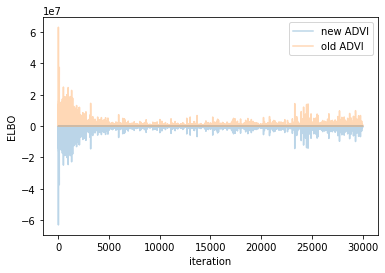

In [37]:
plt.plot(-inference.hist, label='new ADVI', alpha=0.3)
plt.plot(approx.hist, label='old ADVI', alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

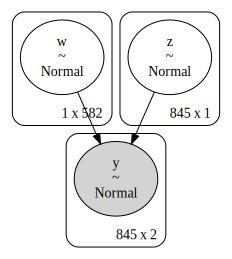

In [38]:
pm.model_to_graphviz(pm_model)

In [40]:
trace = approx.sample(draws=my_draws)
trace = az.from_pymc3(trace, model=pm_model)

### Complete sampling and save/load samples obtained

In [ ]:
# np.save('saved_samples/chicken_samples_pymc3.npy',trace['w'])
posterior_samples_pymc3_chicken = np.load('/Users/lievegobbels/PycharmProjects/decomposition-of-uncertainty/chicken/saved_samples/chicken_samples_pymc3-2.npy')

In [ ]:
posterior_samples_pymc3_chicken.shape

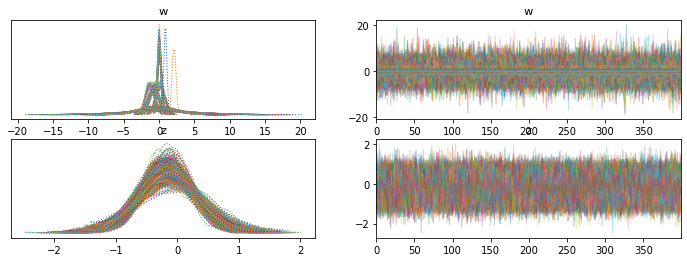

In [41]:
az.plot_trace(trace, combined=True)

plt.savefig('trace_Cnuts.png', dpi=300)

In [42]:
logpost = sns.distplot(trace.get_sampler_stats('model_logp'))
fig = logpost.get_figure()
fig.savefig('logpost_Cnuts.png', dpi=300)

AttributeError: 'InferenceData' object has no attribute 'get_sampler_stats'

/Users/lievegobbels/.local/share/virtualenvs/decomposition-of-uncertainty-uZMjW-bK/lib/python3.7/site-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1427) in plot_posterior, generating only 40 plots
  UserWarning,


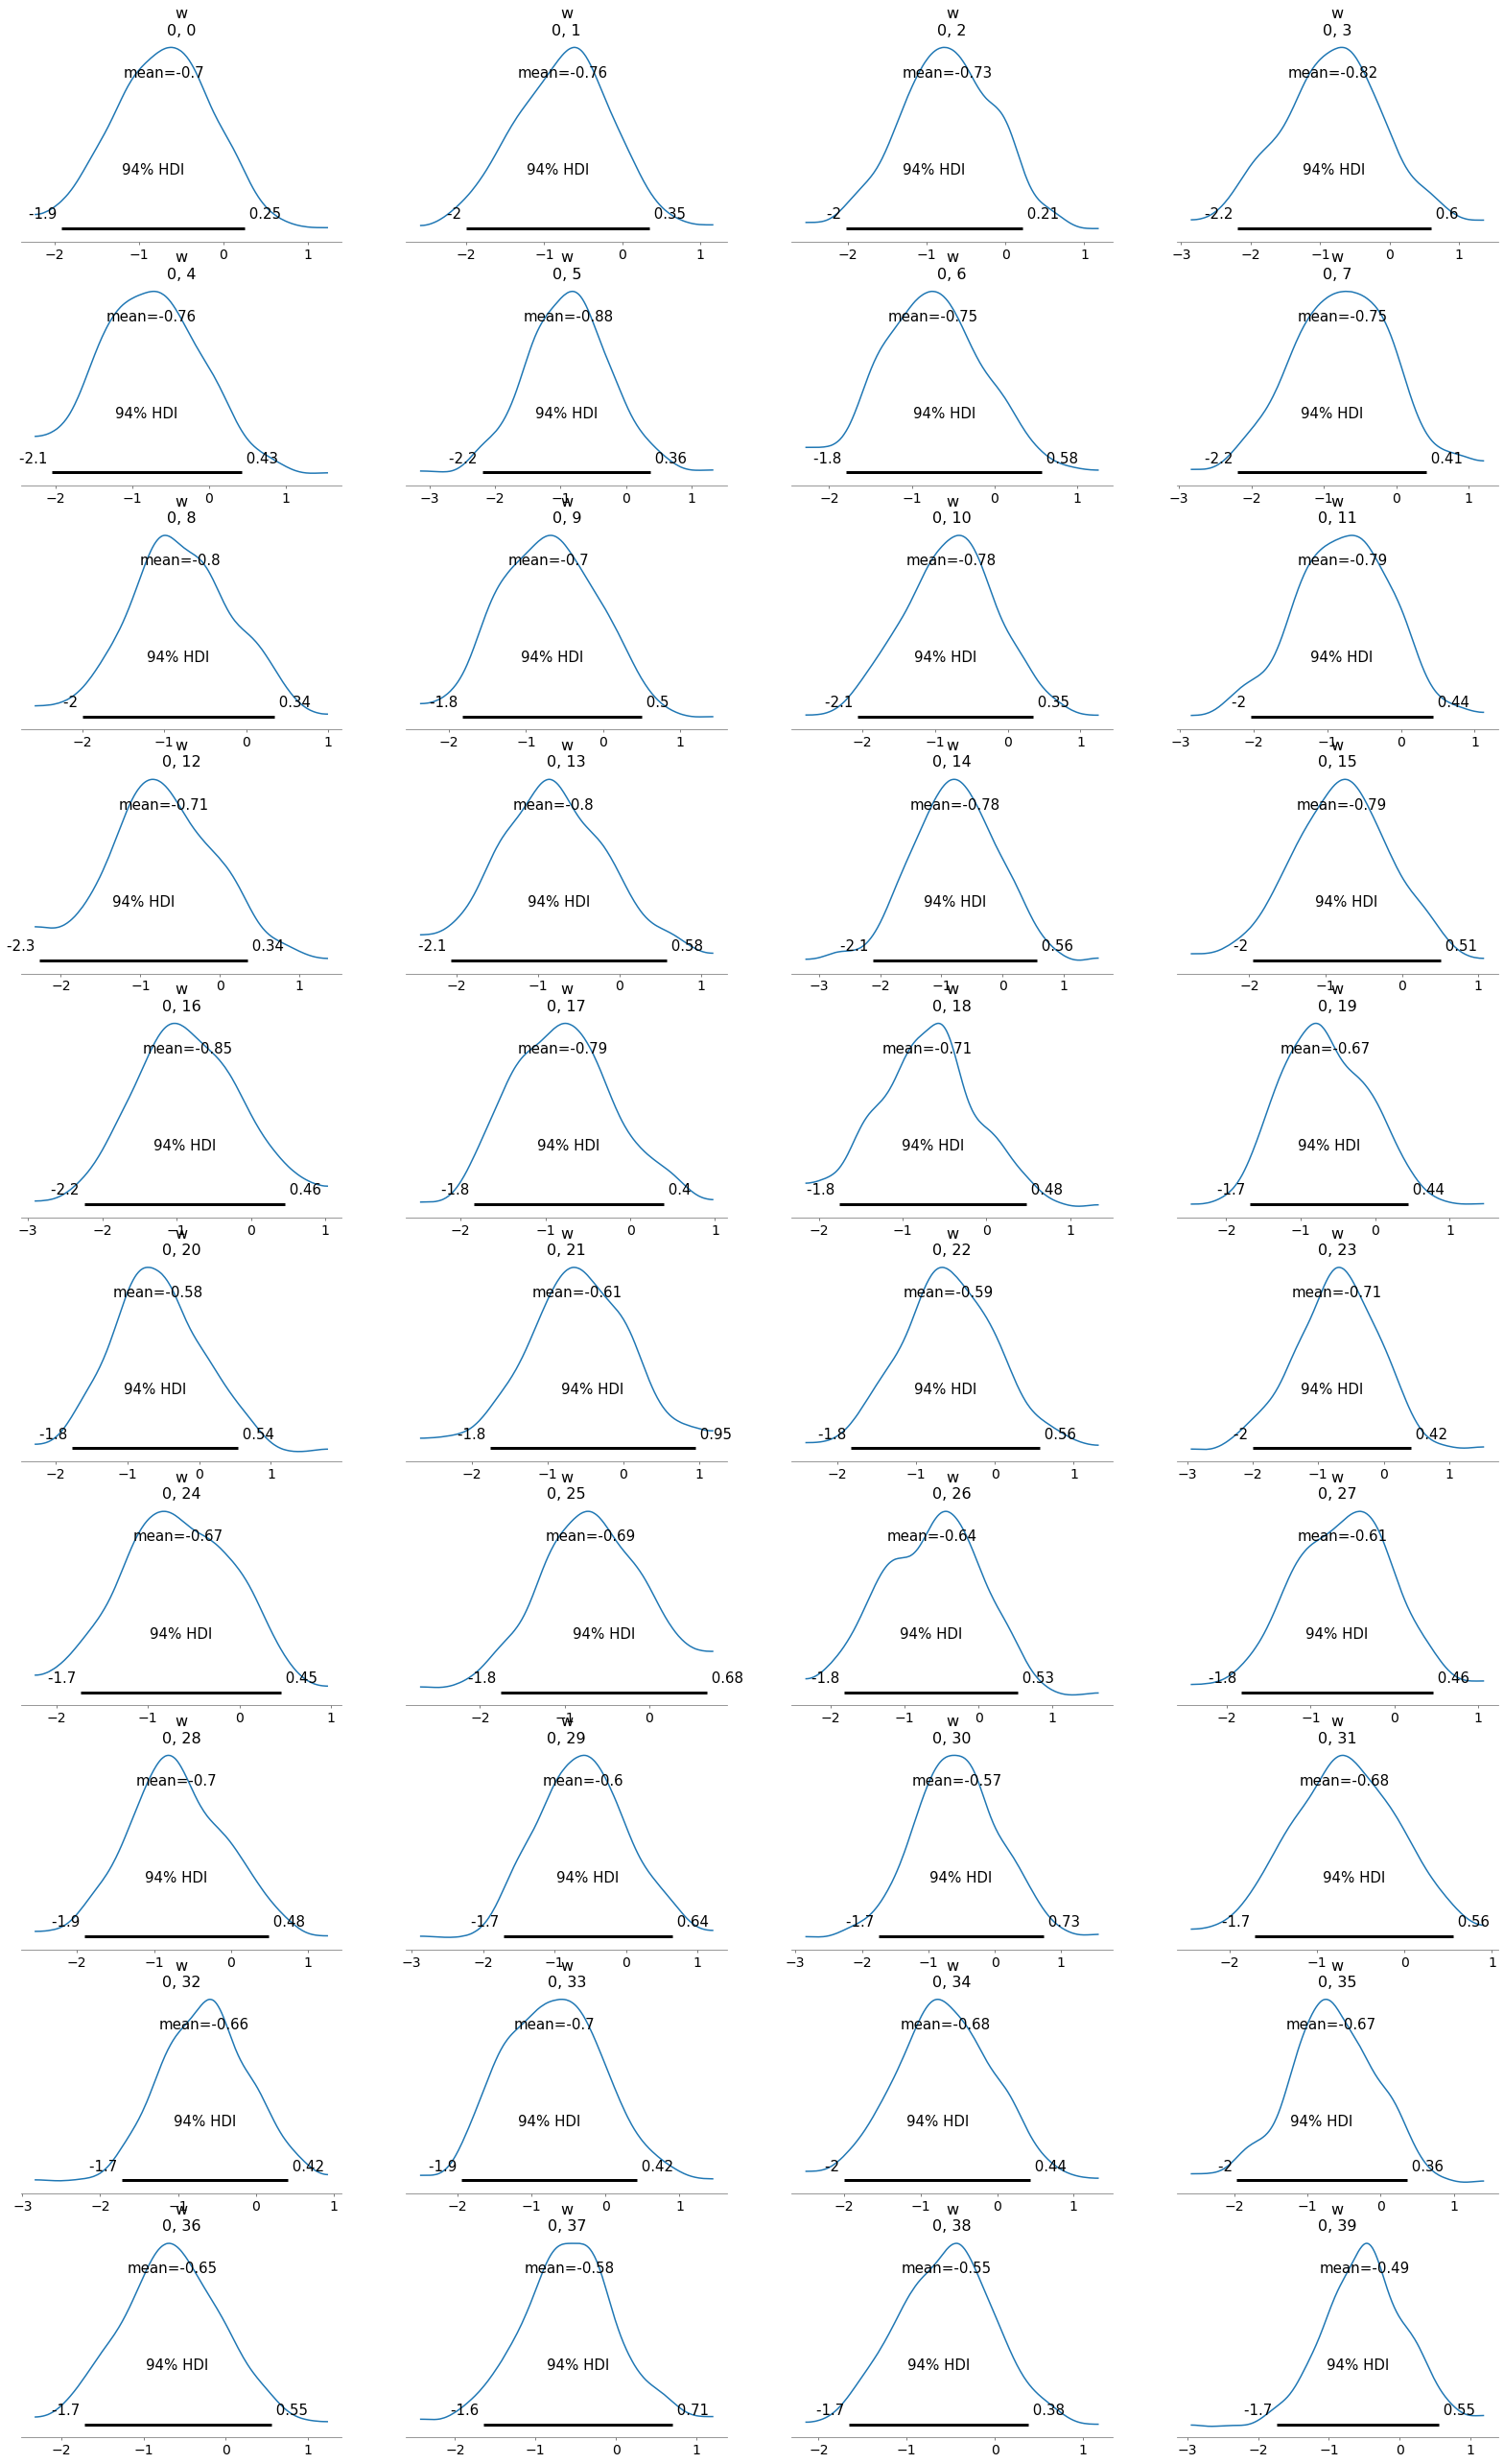

In [43]:
pm.plot_posterior(trace)
plt.savefig('postpw_Cnuts', dpi=300)
pass

In [ ]:
from matplotlib.colors import SymLogNorm

In [ ]:
mu = np.linspace(0,10,100)
sigma = np.linspace(0.5,8,80)
mus, sigmas = np.meshgrid(mu, sigma)

logp = pm_model.logp

def likelihood(mu, sigma):
    return logp({'mu':mu, 'sigma':sigma, 'sigma_log__':np.log(sigma)})

f = np.vectorize(likelihood)
liks = f(mus, sigmas)

sigma_ix, mu_ix = np.unravel_index(np.argmax(liks, liks.shape))

plt.pcolor(mu, sigma, liks, norm=SymLogNorm(0.5))
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.colorbar()
plt.plot(mu[mu_ix], sigma[sigma_ix], 'or')

In [ ]:
# Drop the Z samples and leave just the weights (and drop W resp.)
posterior_samples_nuts_chicken_w = posterior_samples_pymc3_chicken[:,0:bnn_lv_chicken.D]
posterior_samples_nuts_chicken_z = posterior_samples_pymc3_chicken[:,bnn_lv_chicken.D:] #drop W

# Burn in the first 1200 samples
posterior_samples_nuts_chicken_w = posterior_samples_nuts_chicken_w[-4000:, :]
posterior_samples_nuts_chicken_z = posterior_samples_nuts_chicken_z[-4000:, :]

# Thin by a factor of 2
posterior_samples_nuts_chicken_w = posterior_samples_nuts_chicken_w[::2, :]
posterior_samples_nuts_chicken_z = posterior_samples_nuts_chicken_z[::2, :]

# Reshape to correct dimensions
posterior_samples_nuts_chicken_w = posterior_samples_nuts_chicken_w.reshape(posterior_samples_nuts_chicken_w.shape[0], 1, posterior_samples_nuts_chicken_w.shape[-1])

# posterior_samples_nuts_chicken_z = posterior_samples_nuts_chicken_z.reshape(posterior_samples_nuts_chicken_z.shape[0], 1, posterior_samples_nuts_chicken_z.shape[-1])

# Check shape
posterior_samples_nuts_chicken_w.shape
posterior_samples_nuts_chicken_z.shape

In [ ]:
from utils.functions import log_gaussian

def log_likelihood(W, Z):
    mu = bnn_lv_chicken.forward(X = X_train, input_noise = lv_prior, weights=w_prior)
    sigma = l_sigma
    x = Y_train
    return np.sum(log_gaussian(x=x, mu=mu, sigma=sigma))


In [ ]:
log_likelihood(posterior_samples_nuts_chicken_w, posterior_samples_nuts_chicken_z)

In [ ]:
# This might be correct, or at least partially
# there are S*(1*D+N*L)=100*(1427) parameters
#however for each row, there is only one NLL

from utils.models import SamplerModel
from utils.BNN_pymc3 import BNN, BNN_LV
X_test = np.linspace(-6,6,100)

samples = posterior_samples_nuts_chicken_w
#samples = bnn_lv_chicken.get_weights()
#sampler_model = SamplerModel(bnn_lv_chicken) #continue here
neg_LL = SamplerModel.log_likelihood(samples)

# print(len(neg_LL))
df = pd.DataFrame(X_test, columns=['x']) #is this both W and Z or ?
# print(len(samples[:,0]))
df['neg_LL'] = neg_LL.tolist()

best_result = max(neg_LL)
row_best = df.loc[df['neg_LL'] == best_result]
print(row_best)

plt.figure(figsize=(14,7))
#plt.plot(samples, neg_LL, color='blue', marker="o", linestyle='None', alpha=1/5)
plt.plot(df['x'], df['neg_LL'], color='blue') #marker='o'
plt.plot(row_best['x'], row_best['neg_LL'], 'ro')
plt.xlabel("x")
plt.ylabel("negative log-likelihood")
#plt.xlim(-10,10)
plt.grid()
plt.savefig('NLL_Cbbvi1.png', dpi=300)
plt.show();